In [1]:
from matplotlib import font_manager, rc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import platform
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 17년도부터 21년까지의 기온 데이터 전처리 한 것을 불러온다.
tem1721 = pd.read_csv("data/5년기온데이터_전처리.csv").drop(['Unnamed: 0'], axis=1)
# 날짜 컬럼 부분의 6,7,8월 기준으로 해마다 나눠서 다시 저장한다.
tem17210608 = tem1721[tem1721['날짜'].str.contains(
    "2017-06|2017-07|2017-08|2018-06|2018-07|2018-08|2019-06|2019-07|2019-08|2020-06|2020-07|2020-08|2021-06|2021-07|2021-08")].reset_index()
tem17210608.drop('index',axis=1, inplace=True)
tem17210608

,날짜,시간,기온(°C),강수량(mm),풍속(m/s),습도(%)
0,2017-06-01,0:00,21.4,0.0,1.8,74.0
1,2017-06-01,1:00,21.5,0.0,0.9,75.0
2,2017-06-01,2:00,21.3,0.0,1.7,77.0
3,2017-06-01,3:00,20.9,0.0,2.4,81.0
4,2017-06-01,4:00,20.6,0.0,1.1,82.0
...,...,...,...,...,...,...
11035,2021-08-31,19:00,18.1,3.8,3.9,98.0
11036,2021-08-31,20:00,18.1,1.6,4.3,99.0
11037,2021-08-31,21:00,18.1,3.6,3.8,99.0
11038,2021-08-31,22:00,18.3,2.1,3.3,100.0


In [3]:
# 17년부터 21년까지의 수요량 데이터도 같은 방식으로 불러온다
elec1721=pd.read_csv("data/fintime17_21_df.csv")
# 날짜 컬럼 부분의 6,7,8월 기준으로 해마다 나눠서 다시 저장한다.
elec17210608 = elec1721[elec1721['날짜'].str.contains(
    "2017-06|2017-07|2017-08|2018-06|2018-07|2018-08|2019-06|2019-07|2019-08|2020-06|2020-07|2020-08|2021-06|2021-07|2021-08")].reset_index()
elec17210608.drop('index',axis=1, inplace=True)
elec17210608

,날짜,시간,수요량
0,2017-06-01,00:00,58038
1,2017-06-01,01:00,54763
2,2017-06-01,02:00,52836
3,2017-06-01,03:00,51956
4,2017-06-01,04:00,51299
...,...,...,...
11035,2021-08-31,19:00,74786
11036,2021-08-31,20:00,74099
11037,2021-08-31,21:00,71232
11038,2021-08-31,22:00,68114


In [4]:
# 기온 데이터의 시간부분, 수요량 데이터의 날짜 컬럼들을 제거한다.
tem17210608.drop(['시간'], axis=1, inplace=True)
elec17210608.drop(['날짜'], axis=1, inplace=True)

# 두 csv파일을 컬럼 기준으로 합친다
fin17210608 = pd.concat([tem17210608,elec17210608],axis=1)
fin17210608

,날짜,기온(°C),강수량(mm),풍속(m/s),습도(%),시간,수요량
0,2017-06-01,21.4,0.0,1.8,74.0,00:00,58038
1,2017-06-01,21.5,0.0,0.9,75.0,01:00,54763
2,2017-06-01,21.3,0.0,1.7,77.0,02:00,52836
3,2017-06-01,20.9,0.0,2.4,81.0,03:00,51956
4,2017-06-01,20.6,0.0,1.1,82.0,04:00,51299
...,...,...,...,...,...,...,...
11035,2021-08-31,18.1,3.8,3.9,98.0,19:00,74786
11036,2021-08-31,18.1,1.6,4.3,99.0,20:00,74099
11037,2021-08-31,18.1,3.6,3.8,99.0,21:00,71232
11038,2021-08-31,18.3,2.1,3.3,100.0,22:00,68114


In [5]:
# 각 컬럼들의 타입을 추출해본다
fin17210608.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11040 entries, 0 to 11039
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   날짜       11040 non-null  object 
 1   기온(°C)   11040 non-null  float64
 2   강수량(mm)  11040 non-null  float64
 3   풍속(m/s)  11040 non-null  float64
 4   습도(%)    11040 non-null  float64
 5   시간       11040 non-null  object 
 6   수요량      11040 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 603.9+ KB


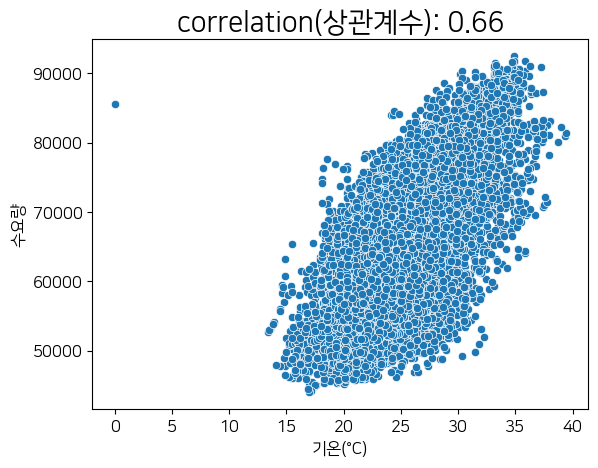

In [6]:
# 수요량과 기온의 상관관계를 구한다. 앞이 y값, 뒤가 x값
correlation = fin17210608['수요량'].corr(fin17210608['기온(°C)'])
# x깂을 기온, y값을 수요량에 맞춰 그래프를 그리게 한다
sns.scatterplot(x=fin17210608['기온(°C)'], y=fin17210608['수요량'])
#그래프 제목을 작성하는 것이다.      소수점 2쨰자리 까지 작성한다     글씨 크기는 20으로
plt.title('correlation(상관계수): '+str(np.round(correlation,2)), fontsize=20)
plt.xlabel("기온(°C)",fontsize=12)
plt.ylabel("수요량",fontsize=12)
plt.show()

In [7]:
# 위 그래프를 보면 이상치가 발견되기에 13도 이상인 데이터들만 추출해본다
fin17210608 = fin17210608.loc[fin17210608['기온(°C)'] > 13]
fin17210608

,날짜,기온(°C),강수량(mm),풍속(m/s),습도(%),시간,수요량
0,2017-06-01,21.4,0.0,1.8,74.0,00:00,58038
1,2017-06-01,21.5,0.0,0.9,75.0,01:00,54763
2,2017-06-01,21.3,0.0,1.7,77.0,02:00,52836
3,2017-06-01,20.9,0.0,2.4,81.0,03:00,51956
4,2017-06-01,20.6,0.0,1.1,82.0,04:00,51299
...,...,...,...,...,...,...,...
11035,2021-08-31,18.1,3.8,3.9,98.0,19:00,74786
11036,2021-08-31,18.1,1.6,4.3,99.0,20:00,74099
11037,2021-08-31,18.1,3.6,3.8,99.0,21:00,71232
11038,2021-08-31,18.3,2.1,3.3,100.0,22:00,68114


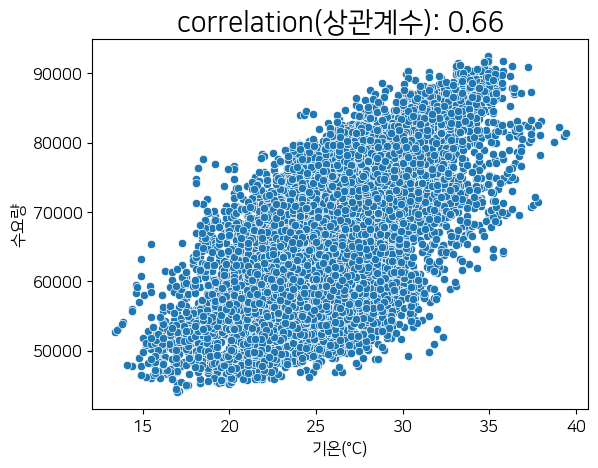

In [8]:
# 다시 위와 마찬가지로 수요량과 기온의 상관관계를 구해본다
correlation = fin17210608['수요량'].corr(fin17210608['기온(°C)'])
# x깂을 기온, y값을 수요량에 맞춰 그래프를 그리게 한다
sns.scatterplot(x=fin17210608['기온(°C)'], y=fin17210608['수요량'])
# 위와 마찬가지로 타이틀 이름         상관계수 값을 소수점 2번째 자리  글
plt.title('correlation(상관계수): '+str(np.round(correlation,2)), fontsize=20)
plt.xlabel("기온(°C)",fontsize=12)
plt.ylabel("수요량",fontsize=12)
plt.show()

In [9]:
# (기온 데이터)선형회귀 > 우리가 필요한 자료는 수요량, 필요한 것은 기론 강수량 풍속 습도이므로 나머지 칼럼들은 제거하고, 필요자료인 y값도 제거한다.
y = fin17210608['수요량']
x = fin17210608.drop(columns=['날짜', '시간', '수요량'])

In [10]:
# 70퍼센트의 데이터를 test set으로 설정하고 학습시킨다 
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3)
x_train, x_test, y_train, y_test

(       기온(°C)  강수량(mm)  풍속(m/s)  습도(%)
 872      26.5      0.0      1.9   75.0
 6586     23.3      0.0      1.9   58.0
 7060     21.7      0.0      2.4   69.0
 8835     18.8      0.0      1.6   86.0
 3581     28.1      0.0      0.5   84.0
 ...       ...      ...      ...    ...
 1694     25.6      0.0      1.9   90.0
 10924    24.6      0.0      0.6   90.0
 6332     27.9      0.0      0.8   53.0
 6230     25.7      5.2      1.3   95.0
 7249     21.0      0.0      1.2   79.0
 
 [7727 rows x 4 columns],
        기온(°C)  강수량(mm)  풍속(m/s)  습도(%)
 9004     19.1      0.0      1.7   83.0
 8326     26.1      0.0      1.7   95.0
 7192     20.7      0.3      3.3   94.0
 3219     24.9      0.0      2.0   86.0
 10691    29.0      0.0      2.4   53.0
 ...       ...      ...      ...    ...
 4994     20.5      0.0      1.1   69.0
 4852     19.2      0.0      1.9   88.0
 228      23.0      0.0      3.2   26.0
 4355     26.9      0.0      3.2   74.0
 1838     26.4      0.0      4.0   68.0
 
 [3312 row

In [11]:
# lr에 선형회귀를 저장
lr = LinearRegression()
y = fin17210608['수요량']
x = fin17210608.drop(columns=['날짜', '시간', '수요량'])
# (교차검증)수요량을 기준으로 기온 데이터 선형회귀를 5번(cv = 5)돌린다. neg_mean_squared_error 쓰면 mse값이 음수가 되기에
neg_mse = cross_val_score(lr,x,y,scoring='neg_mean_squared_error', cv=5)
# 실제 출력되기 전에 mse값에 -값을 부여한다.
mse = -neg_mse
# mse 에 루트를 씌운다 > 즉 mse값은 -5억 언저리다
rmse = np.sqrt(mse)
np.mean(rmse)

7360.186759690502

In [12]:
from sklearn.preprocessing import StandardScaler

# StandardScaler > 함수 데이터를 평균이 0 표준편차가 1인 값으로 변환
scaler = StandardScaler()

# x_train 데이터를 평균이 0이고 표준 편차가 1인 값으로 변환
x_train_scaled = scaler.fit_transform(x_train)
# x_test 데이터를 x_train 데이터를 사용하여 구한 평균과 표준 편차를 사용하여 변환
x_test_scaled = scaler.transform(x_test)

scaler_y = StandardScaler()

# y_train 값의 행렬 위치를 바꿔서 평균이 0 표준편차가 1인 값으로 변환한다
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# LinearRegression() 함수로 선형 회귀 모델을 훈련시키고, 테스트 데이터에 대한 예측 값을 계산
lr = LinearRegression()
# train_scaled와 y_train_scaled 데이터를 사용하여 선형 회귀 모델을 훈련시키는 과정
lr.fit(x_train_scaled, y_train_scaled)
# 테스트 데이터 x_test_scaled를 사용하여 예측 값을 계산
y_pred = lr.predict(x_test_scaled)

# 그런 다음 mean_squared_error(), r2_score() 함수를 사용하여 모델의 성능을 평가합니다. 
# MSE는 실제 값과 예측 값의 차이를 제곱한 값들의 평균이며, RMSE는 MSE의 제곱근입니다. 
# r2 score는 모델이 얼마나 잘 예측하는지에 대한 지표입니다

# 위와 마찬가지로 실제값과 예측값의 차이를 제곱한 값들의 평균을 구한다
mse = mean_squared_error(y_test_scaled, y_pred)
# 루트 값을 씌우고
rmse = np.sqrt(mse)
# 얼마나 잘 예측했는지 보여쥰다
r2 = r2_score(y_test_scaled, y_pred)
print(f'mse:{mse}, rmse:{rmse}, r2:{r2}')

mse:0.5569775301987507, rmse:0.7463092724861127, r2:0.46056975913618114


In [13]:
# train_set 과 test_set의 예측값을 보여준다
print(lr.score(x_train_scaled, y_train_scaled))
print(lr.score(x_test_scaled, y_test_scaled))

0.46112698980449984
0.46056975913618114


In [14]:
# 다항 회귀 모델을 학습
from sklearn.preprocessing import PolynomialFeatures

# x_train_scaled와 x_test_scaled에 3차 다항식항을 추가하여 다항 회귀 모델을 학습
poly = PolynomialFeatures(degree=3)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

# LinearRegression > x_train_poly를 입력으로 사용하여 y_train_scaled 값을 예측하는 방법을 학습
lr = LinearRegression()
lr.fit(x_train_poly, y_train_scaled)
y_pred = lr.predict(x_test_poly)

# 예측값 y_pred 와 y_test_scaled간의 평균제곱오차, 평균제곱근오차, 결정계수 값을 계산
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_scaled, y_pred)
print(f'mse:{mse}, rmse:{rmse}, r2:{r2}')

mse:0.5134452219187043, rmse:0.7165509206739632, r2:0.5027306045341704


In [15]:
# 각각 train test의 정확도가 50, 49퍼센트인것을 볼 수 있다
print(lr.score(x_train_poly, y_train_scaled))
print(lr.score(x_test_poly, y_test_scaled))

0.49877301323849543
0.5027306045341704


In [16]:
# 릿지 라쏘
ridge_reg = Ridge()
ridge_reg.fit(x_train_poly, y_train_scaled)

lasso_reg = Lasso()
lasso_reg.fit(x_test_poly,  y_test_scaled)

Lasso()

In [17]:
def print_best_params(model,params):
    # GridSearchCV 최적의 하이퍼파라미터 찾기
    from sklearn.model_selection import GridSearchCV
    grid_model = GridSearchCV(model,
                              # 모델의 하이퍼파라미터들을 설정, 최적의 조합을 찾는것
                              param_grid=params,
                              # 성능 평가 지표지정, 음수값 사용
                              scoring='neg_mean_squared_error',
                              # 20회 반복학습
                              cv=20)
    # GridSearch 를 수행하며, x_train_poly, y_train_scaled를 사용하여 모델훈련을 한다
    grid_model.fit(x_train_poly,y_train_scaled)
    rmse = np.sqrt(-grid_model.best_score_)
    print(f'최적 rmse:{rmse}, 최적 alpha :{grid_model.best_params_}')

In [18]:
# 임의로 릿지 랏소에 알파값들을 넣어본다 그래서 최적의 rmse값과 alpha 값을 추출한다.
ridge_params = {'alpha':[10, 50, 100, 200, 300, 500, 1000]}
lasso_params = {'alpha':[0.01, 0.05, 0.1, 1, 10, 100, 300]}
print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)

최적 rmse:0.7166361092553198, 최적 alpha :{'alpha': 10}
최적 rmse:0.7155223065278964, 최적 alpha :{'alpha': 0.01}


In [19]:
# 상관계수가 너무 작아서 정확도가 떨어진다
ridge = Ridge(alpha=10)
ridge.fit(x_train_poly, y_train_scaled)
print(ridge.score(x_train_poly, y_train_scaled))
print(ridge.score(x_test_poly, y_test_scaled))

0.4986645615237417
0.5030442307072176


In [20]:
# 위와 마찬가지
lasso = Lasso(alpha=0.01)
lasso.fit(x_train_poly, y_train_scaled)
print(lasso.score(x_train_poly, y_train_scaled))
print(lasso.score(x_test_poly, y_test_scaled))

0.4931802434491517
0.49419940646755967
